<a href="https://colab.research.google.com/github/parham/glo7030_Travail_Pratique_2/blob/main/question_2_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [40]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [41]:
!cp -R "/content/drive/MyDrive/DL - GLO7030/Development/glo7030_Travail_Pratique_2/img" .

 ![Université Laval](https://github.com/parham/glo7030_Travail_Pratique_2/blob/main/img/ulaval.jpg?raw=1)
 # <center><b>GLO-4030/GLO-7030 : Apprentissage par réseaux de neurones profonds</b> </center>
 # <center><b>Travail Pratique 2</b></center>
 ***
 __Course__: GLO-4030/GLO-7030 : Apprentissage par réseaux de neurones profonds <br>
 __Title__: Travail Pratique 2 <br>
 __Semester__: Winter 2021 <br>
 __Lecturer__: Dr. Pascal Germain <br>
 __Author__: Parham Nooralishahi <br>
 __Organization__: Université Laval <br>
 ***

 ## Question 2 - Neural Style Transfer (45%)

 This code is modified version of <a href="https://pytorch.org/tutorials/advanced/neural_style_tutorial.html">PyTorch Tutorial</a>

 ## NEURAL TRANSFER USING PYTORCH
 This code explains how to implement the Neural-Style algorithm developed by Leon A. Gatys, Alexander S. Ecker and Matthias Bethge. Neural-Style, or Neural-Transfer, allows you to take an image and reproduce it with a new artistic style. <br>


 __What does it need?__ The algorithm takes three images, an input image, a content-image, and a style-image. <br>

 __What does it provide?__ It changes the input to resemble the content of the content-image and the artistic style of the style-image. <br>

 #### Underlying Principle
 The principle is simple: we define two distances, one for the content $D_C$ and one for the style $D_S$. $D_C$ measures how different the content is between two images while $D_S$ measures how different the style is between two images. Then, we take a third image, the input, and transform it to minimize both its content-distance with the content-image and its style-distance with the style-image. Now we can import the necessary packages and begin the neural transfer. <br>

 #### The required packages
 * torch, torch.nn, numpy (indispensables packages for neural networks with PyTorch)
 * torch.optim (efficient gradient descents)
 * PIL, PIL.Image, matplotlib.pyplot (load and display images)
 * torchvision.transforms (transform PIL images into tensors)
 * torchvision.models (train or load pre-trained models)
 * copy (to deep copy the models; system package)

In [42]:
from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import os
import shutil
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy


 Next, we need to choose which device to run the network on and import the content and style images. Running the neural transfer algorithm on large images takes longer and will go much faster when running on a GPU.

In [43]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


  ### Content Loss

 The content loss is a function that represents a weighted version of the content distance for an individual layer. The function takes the feature maps of a layer in a network processing input and returns the weighted content distance between the image and the content image. The distance $∥FXL−FCL∥^2$ is the mean square error between the two sets of feature maps. <br>

 We will add this content loss module directly after the convolution layer(s) that are being used to compute the content distance. This way each time the network is fed an input image the content losses will be computed at the desired layers and because of auto grad, all the gradients will be computed. <br>

In [44]:
class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input


  ### Style Loss

 The style loss module is implemented similarly to the content loss module. It will act as a transparent layer in a network that computes the style loss of that layer. In order to calculate the style loss, we need to compute the gram matrix. <br>

 A gram matrix is the result of multiplying a given matrix by its transposed matrix. In this application the given matrix is a reshaped version of the feature maps of a layer. <br>

In [45]:
def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d)  # resise F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)

class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input


 ### Normalization

 VGG networks are trained on images with each channel normalized by mean=[0.485, 0.456, 0.406] and std=[0.229, 0.224, 0.225]. We will use them to normalize the image before sending it into the network. <br>

In [46]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

# create a module to normalize input image so we can easily put it in a nn.Sequential.

class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize img
        return (img - self.mean) / self.std


 ### Importing Neural Network's model

 We will use a 19 layer VGG network like the one used in the related paper.
 PyTorch’s implementation of VGG is a module divided into two child Sequential modules: features (containing convolution and pooling layers), and classifier (containing fully connected layers). We will use the features module because we need the output of the individual convolution layers to measure content and style loss. Some layers have different behavior during training than evaluation, so we must set the network to evaluation mode using .eval(). <br>

In [47]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()


 ### Module Initialization

 A Sequential module contains an ordered list of child modules. For instance, vgg19.features contains a sequence (Conv2d, ReLU, MaxPool2d, Conv2d, ReLU…) aligned in the right order of depth. We need to add our content loss and style loss layers immediately after the convolution layer they are detecting. To do this we must create a new Sequential module that has content loss and style loss modules correctly inserted. <br>

In [48]:

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=['conv_4'],
                               style_layers=['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']):
    cnn = copy.deepcopy(cnn)

    # normalization module
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    # just in order to have an iterable access to or list of content/syle
    # losses
    content_losses = []
    style_losses = []

    # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ContentLoss
            # and StyleLoss we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses


 ### Gradient Descent

 we will use L-BFGS algorithm to run our gradient descent. Unlike training a network, we want to train the input image in order to minimise the content/style losses. <br>

In [49]:
def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.LBFGS([input_img.requires_grad_()])
    return optimizer


 ### Transfer Learning

 Finally, we must define a function that performs the neural transfer. For each iteration of the networks, it is fed an updated input and computes new losses. We will run the backward methods of each loss module to dynamicaly compute their gradients. The optimizer requires a “closure” function, which reevaluates the module and returns the loss. <br>

 We still have one final constraint to address. The network may try to optimize the input with values that exceed the 0 to 1 tensor range for the image. We can address this by correcting the input values to be between 0 to 1 each time the network is run. <br>

In [50]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
    content_img, style_img, input_img, content_layers, style_layers,
    num_steps=300, style_weight=1000000, content_weight=1,
):
    """Run the style transfer."""
    print('Building the style transfer model..')

    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img,
        content_layers=content_layers, style_layers=style_layers)

    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

    # a last correction...
    input_img.data.clamp_(0, 1)

    return input_img



 ### Loading the Images
  Now we will import the style and content images. The original PIL images have values between 0 and 255, but when transformed into torch tensors, their values are converted to be between 0 and 1. The images also need to be resized to have the same dimensions. An important detail to note is that neural networks from the torch library are trained with tensor values ranging from 0 to 1. If you try to feed the networks with 0 to 255 tensor images, then the activated feature maps will be unable to sense the intended content and style. However, pre-trained networks from the Caffe library are trained with 0 to 255 tensor images. <br>

 #### Determining Output Size
 For the first step, the desired size for the output will be determined based on available devices (the computation power).

In [51]:
imsize = 512 if torch.cuda.is_available() else 128  # use small size if no gpu


 #### Defining transform operations

In [52]:
loader = transforms.Compose([
    transforms.Resize(imsize),  # scale imported image
    transforms.ToTensor()])  # transform it into a torch tensor


 #### Defining a method to load the images

In [53]:
def image_loader(image_name):
    image = Image.open(image_name)
    # fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)


 #### Defining how to display images

In [54]:
unloader = transforms.ToPILImage()  # reconvert into PIL image

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated
    return image


 ### Defining a method as an entry point for the whole processing pipeline

In [55]:
def run_pipeline(
    res_path,
    content_img_path : str, 
    style_img_path : str, 
    input_img = None,
    content_layers= ['conv_4'],
    style_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5'],
    style_weight = 1000000,
    content_weight = 1,
    num_steps=300,
    check_img_size = True
):
    if not os.path.isfile(style_img_path) or not os.path.isfile(content_img_path):
        print('ERROR: one or more of the input images does/do not exist!')
        return

    style_img = image_loader(style_img_path)
    content_img = image_loader(content_img_path)

    # shutil.copy(style_img_path, res_path)
    # shutil.copy(content_img_path, res_path)

    if check_img_size:
        assert style_img.size() == content_img.size(), \
            "we need to import style and content images of the same size"
    
    plt.ion()

    if input_img is None:
        # if you want to use white noise instead uncomment the below line:
        # input_img = torch.randn(content_img.data.size(), device=device)
        input_img = content_img.clone()
    else:
        plt.figure()
        imshow(input_img, title='Input Image')

    plt.figure()
    imshow(style_img, title='Style Image')

    plt.figure()
    imshow(content_img, title='Content Image')

    output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
        content_img, style_img, input_img, num_steps=num_steps, 
        content_layers=content_layers, style_layers=style_layers,
        style_weight=style_weight, content_weight=content_weight)
    
    plt.figure()
    res_out = imshow(output, title='Output Image')
    res_out.save(res_path)

    plt.ioff()
    plt.show()


 # Experiments

 ## Data Preparation

 For this question one content image and three style image is selected which are employed in the following experiments. <br>

 ### Selected Content Images
 This image is an thermal image of my face :D captured by DALSA Teledyne GXM640. <br>

 ![My Face](https://github.com/parham/glo7030_Travail_Pratique_2/blob/main/img/content_1.jpg?raw=1)

 ### Selected Style Images

 The first image is a <a href="https://www.nasa.gov/mission_pages/hubble/multimedia/index.html">the luminous heart of the galaxy M61</a> dominates this image, framed by its winding spiral arms threaded with dark tendrils of dust.

 ![Glaxy](https://github.com/parham/glo7030_Travail_Pratique_2/blob/main/img/style_1.jpg?raw=1)


 The second image is a <a href="https://www.scientificamerican.com/slideshow/small-world-microscope-photography/">magmatic rock olivine</a> (a mineral which in a pure form is the germ peridot) inclusions, rumbles in at just 5x magnification. Bernardo Cesare of the University of Padova's Geoscience Department in Italy captured them with a polarized transmitted-light microscope. This image won the nineth place in the 20 Microscopic Photo Competition Prizewinners.

 ![Microscopic](https://github.com/parham/glo7030_Travail_Pratique_2/blob/main/img/style_2.jpg?raw=1)


 The last image is a Picasso painting named <a href="https://www.pablopicasso.org/seated-nude.jsp">Seated Nude (1909)</a>.
  Seated Nude is part of a series from late 1909 to spring 1910, and a summation of earlier Cubist three-dimensional experimental work on still life and portraits. In fact, this time of experiment and research gives this period the title of Analytical Cubism, with its manipulation and fragmentation of space and multiple angles of vision Picasso whole preoccupation with the notion of vision, explored in the earlier blind man images, now finds its thematic challenge in Cubis.

 ![Picasso](https://github.com/parham/glo7030_Travail_Pratique_2/blob/main/img/picasso.jpg?raw=1)

In [56]:
result_dir = 'results/question_2'
Path(result_dir).mkdir(parents=True, exist_ok=True)


 ## Experiment 1-a : original values for hyperparameters

 |__Parameter__|__Value__|
 |---------|-----|
 |__Content Layers__|conv_4|
 |__Style Layers__|conv_1, conv_2, conv_3, conv_4, conv_5|
 |__Style Weight__|1000000|
 |__Content Weight__|1|

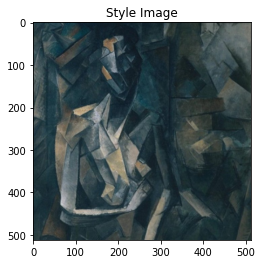

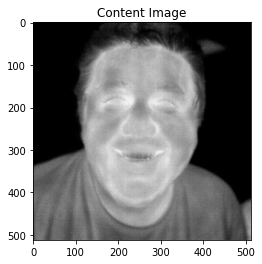

Building the style transfer model..
Optimizing..


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


run [50]:
Style Loss : 28.966948 Content Loss: 6.098665

run [100]:
Style Loss : 15.208214 Content Loss: 5.483789

run [150]:
Style Loss : 10.662273 Content Loss: 4.847088

run [200]:
Style Loss : 6.458990 Content Loss: 4.510332

run [250]:
Style Loss : 3.336754 Content Loss: 4.179364

run [300]:
Style Loss : 1.608342 Content Loss: 3.937797



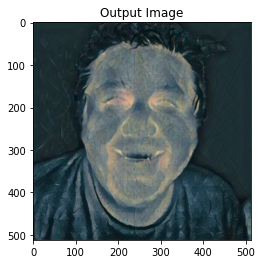

In [57]:
result_path = os.path.join(result_dir,'experiment_1_a.jpg')
run_pipeline(
    result_path,
    content_img_path = 'img/content_1.jpg', 
    style_img_path = 'img/picasso.jpg', 
    content_layers= ['conv_4'],
    style_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5'],
    style_weight = 1000000,
    content_weight = 1,
    num_steps=300,
    check_img_size = True
)


 ## Experiment 1-b : other selection of layers to calculate the loss functions

 |__Parameter__|__Value__|
 |---------|-----|
 |__Content Layers__|conv_2, conv_4, conv_5|
 |__Style Layers__|conv_3, conv_4, conv_5|
 |__Style Weight__|1000000|
 |__Content Weight__|1|

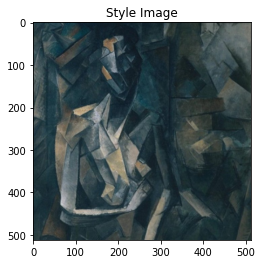

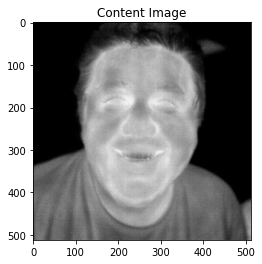

Building the style transfer model..
Optimizing..


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


run [50]:
Style Loss : 29.101648 Content Loss: 14.613400

run [100]:
Style Loss : 14.369710 Content Loss: 12.419078

run [150]:
Style Loss : 10.302640 Content Loss: 11.383980

run [200]:
Style Loss : 5.838666 Content Loss: 11.341329

run [250]:
Style Loss : 2.830280 Content Loss: 11.045654

run [300]:
Style Loss : 1.437017 Content Loss: 10.804846



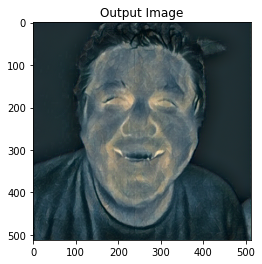

In [58]:
result_path = os.path.join(result_dir,'experiment_1_b.jpg')
run_pipeline(
    result_path,
    content_img_path = 'img/content_1.jpg', 
    style_img_path = 'img/picasso.jpg', 
    content_layers= ['conv_2', 'conv_4', 'conv_5'],
    style_layers = ['conv_1', 'conv_2', 'conv_5'],
    style_weight = 1000000,
    content_weight = 1,
    num_steps=300,
    check_img_size = True
)


 ## Experiment 1-c : first combination for style loss (style weight) and content loss (content weight)

 |__Parameter__|__Value__|
 |---------|-----|
 |__Content Layers__|conv_4|
 |__Style Layers__|conv_1, conv_2, conv_3, conv_4, conv_5|
 |__Style Weight__|8000000|
 |__Content Weight__|1|

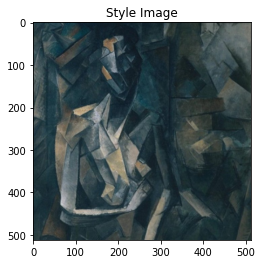

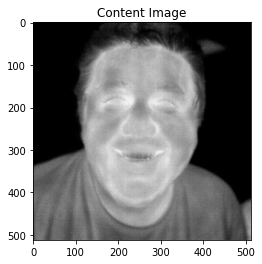

Building the style transfer model..
Optimizing..


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


run [50]:
Style Loss : 580.378479 Content Loss: 10.146282

run [100]:
Style Loss : 223.890106 Content Loss: 9.965758

run [150]:
Style Loss : 143.747101 Content Loss: 9.450855

run [200]:
Style Loss : 94.765762 Content Loss: 8.851700

run [250]:
Style Loss : 61.614971 Content Loss: 8.271235

run [300]:
Style Loss : 30.963867 Content Loss: 7.830579



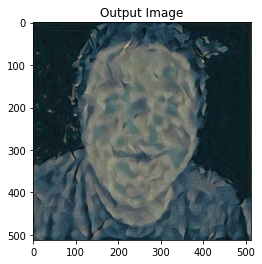

In [59]:
result_path = os.path.join(result_dir,'experiment_1_c.jpg')
run_pipeline(
    result_path,
    content_img_path = 'img/content_1.jpg', 
    style_img_path = 'img/picasso.jpg', 
    content_layers= ['conv_4'],
    style_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5'],
    style_weight = 8000000,
    content_weight = 1,
    num_steps=300,
    check_img_size = True
)


 ## Experiment 1-d : second combination for style loss (style weight) and content loss (content weight).

 |__Parameter__|__Value__|
 |---------|-----|
 |__Content Layers__|conv_4|
 |__Style Layers__|conv_1, conv_2, conv_3, conv_4, conv_5|
 |__Style Weight__|1000000|
 |__Content Weight__|200|

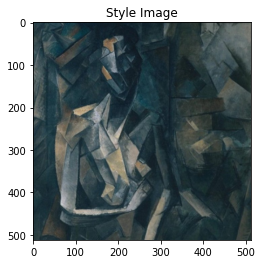

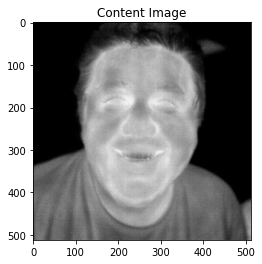

Building the style transfer model..
Optimizing..


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


run [50]:
Style Loss : 185.103241 Content Loss: 173.959045

run [100]:
Style Loss : 133.744156 Content Loss: 175.887192

run [150]:
Style Loss : 128.721405 Content Loss: 174.555725

run [200]:
Style Loss : 120.047508 Content Loss: 178.535843

run [250]:
Style Loss : 112.137741 Content Loss: 185.283783

run [300]:
Style Loss : 111.514793 Content Loss: 178.826813



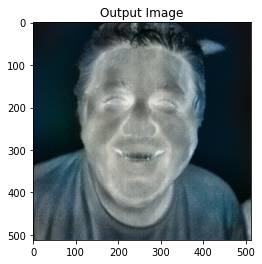

In [60]:
result_path = os.path.join(result_dir,'experiment_1_d.jpg')
run_pipeline(
    result_path,
    content_img_path = 'img/content_1.jpg', 
    style_img_path = 'img/picasso.jpg', 
    content_layers= ['conv_4'],
    style_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5'],
    style_weight = 1000000,
    content_weight = 200,
    num_steps=300,
    check_img_size = True
)


 ## Experiment 1-e : third combination for style loss (style weight) and content loss (content weight)

 |__Parameter__|__Value__|
 |---------|-----|
 |__Content Layers__|conv_4|
 |__Style Layers__|conv_1, conv_2, conv_3, conv_4, conv_5|
 |__Style Weight__|80|
 |__Content Weight__|1|

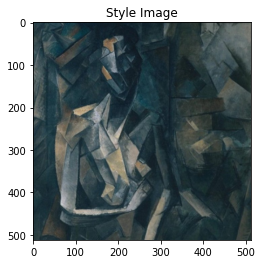

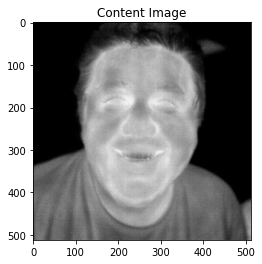

Building the style transfer model..
Optimizing..


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


run [50]:
Style Loss : 0.060335 Content Loss: 0.001592

run [100]:
Style Loss : 0.060030 Content Loss: 0.001742

run [150]:
Style Loss : 0.059930 Content Loss: 0.001786

run [200]:
Style Loss : 0.059876 Content Loss: 0.001809

run [250]:
Style Loss : 0.059831 Content Loss: 0.001824

run [300]:
Style Loss : 0.059789 Content Loss: 0.001837



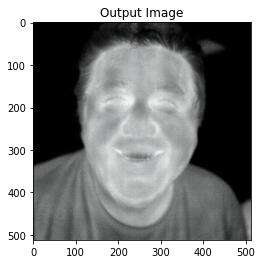

In [61]:
result_path = os.path.join(result_dir,'experiment_1_e.jpg')
run_pipeline(
    result_path,
    content_img_path = 'img/content_1.jpg', 
    style_img_path = 'img/picasso.jpg', 
    content_layers= ['conv_4'],
    style_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5'],
    style_weight = 80,
    content_weight = 1,
    num_steps=300,
    check_img_size = True
)


 ## Experiment 1-f : third combination for style loss (style weight) and content loss (content weight)

 |__Parameter__|__Value__|
 |---------|-----|
 |__Content Layers__|conv_1|
 |__Style Layers__|conv_1|
 |__Style Weight__|80|
 |__Content Weight__|1|

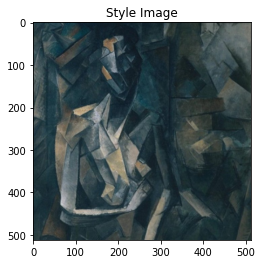

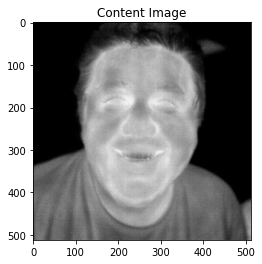

Building the style transfer model..
Optimizing..


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


run [50]:
Style Loss : 0.001403 Content Loss: 0.000000

run [100]:
Style Loss : 0.001403 Content Loss: 0.000000

run [150]:
Style Loss : 0.001403 Content Loss: 0.000000

run [200]:
Style Loss : 0.001403 Content Loss: 0.000000

run [250]:
Style Loss : 0.001403 Content Loss: 0.000000

run [300]:
Style Loss : 0.001403 Content Loss: 0.000000



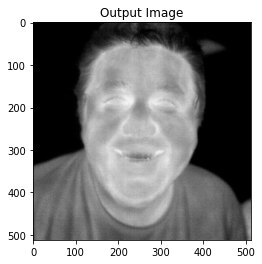

In [62]:
result_path = os.path.join(result_dir,'experiment_1_f.jpg')
run_pipeline(
    result_path,
    content_img_path = 'img/content_1.jpg', 
    style_img_path = 'img/picasso.jpg', 
    content_layers= ['conv_1'],
    style_layers = ['conv_1'],
    style_weight = 80,
    content_weight = 1,
    num_steps=300,
    check_img_size = True
)


 ## Experiment 1-g : third combination for style loss (style weight) and content loss (content weight)

 |__Parameter__|__Value__|
 |---------|-----|
 |__Content Layers__|conv_1|
 |__Style Layers__|conv_5|
 |__Style Weight__|80|
 |__Content Weight__|1|

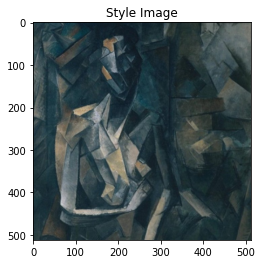

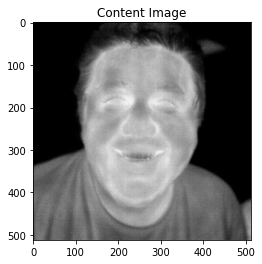

Building the style transfer model..
Optimizing..


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


run [50]:
Style Loss : 0.001642 Content Loss: 0.002876

run [100]:
Style Loss : 0.001629 Content Loss: 0.002917

run [150]:
Style Loss : 134.980804 Content Loss: 4.746661

run [200]:
Style Loss : 0.003006 Content Loss: 0.012827

run [250]:
Style Loss : 0.001737 Content Loss: 0.003396

run [300]:
Style Loss : 0.001772 Content Loss: 0.005209



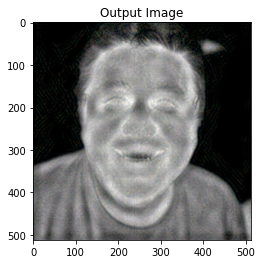

In [63]:
result_path = os.path.join(result_dir,'experiment_1_g.jpg')
run_pipeline(
    result_path,
    content_img_path = 'img/content_1.jpg', 
    style_img_path = 'img/picasso.jpg', 
    content_layers= ['conv_1'],
    style_layers = ['conv_5'],
    style_weight = 80,
    content_weight = 1,
    num_steps=300,
    check_img_size = True
)


 ## Experiment 2-a : original values for hyperparameters

 |__Parameter__|__Value__|
 |---------|-----|
 |__Content Layers__|conv_4|
 |__Style Layers__|conv_1, conv_2, conv_3, conv_4, conv_5|
 |__Style Weight__|1000000|
 |__Content Weight__|1|

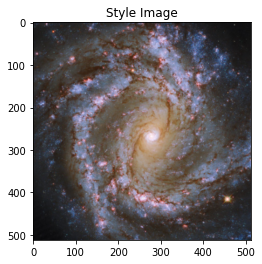

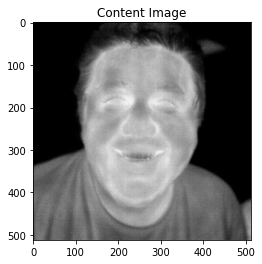

Building the style transfer model..
Optimizing..


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


run [50]:
Style Loss : 34.723724 Content Loss: 15.158754

run [100]:
Style Loss : 7.948288 Content Loss: 13.625402

run [150]:
Style Loss : 5.098371 Content Loss: 11.813029

run [200]:
Style Loss : 3.615774 Content Loss: 10.605558

run [250]:
Style Loss : 2.724053 Content Loss: 9.643488

run [300]:
Style Loss : 1.914101 Content Loss: 8.899419



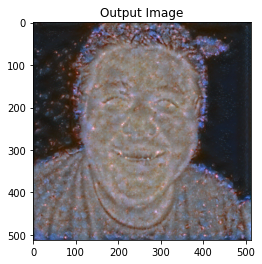

In [64]:
result_path = os.path.join(result_dir,'experiment_2_a.jpg')
run_pipeline(
    result_path,
    content_img_path = 'img/content_1.jpg', 
    style_img_path = 'img/style_1.jpg', 
    content_layers= ['conv_4'],
    style_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5'],
    style_weight = 1000000,
    content_weight = 1,
    num_steps=300,
    check_img_size = True
)


 ## Experiment 2-b : other selection of layers to calculate the loss functions

 |__Parameter__|__Value__|
 |---------|-----|
 |__Content Layers__|conv_2, conv_4, conv_5|
 |__Style Layers__|conv_3, conv_4, conv_5|
 |__Style Weight__|1000000|
 |__Content Weight__|1|

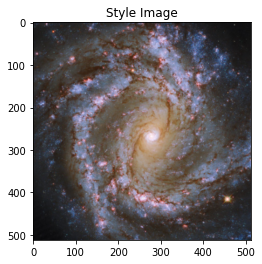

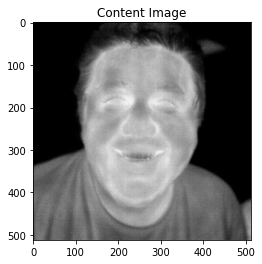

Building the style transfer model..
Optimizing..


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


run [50]:
Style Loss : 37.075275 Content Loss: 32.074150

run [100]:
Style Loss : 11.179496 Content Loss: 30.234135

run [150]:
Style Loss : 5.390839 Content Loss: 28.192362

run [200]:
Style Loss : 3.992793 Content Loss: 27.049324

run [250]:
Style Loss : 2.937460 Content Loss: 26.472849

run [300]:
Style Loss : 2.085814 Content Loss: 26.087496



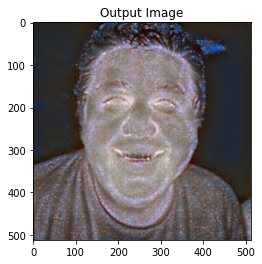

In [65]:
result_path = os.path.join(result_dir,'experiment_2_b.jpg')
run_pipeline(
    result_path,
    content_img_path = 'img/content_1.jpg', 
    style_img_path = 'img/style_1.jpg', 
    content_layers= ['conv_2', 'conv_4', 'conv_5'],
    style_layers = ['conv_1', 'conv_2', 'conv_5'],
    style_weight = 1000000,
    content_weight = 1,
    num_steps=300,
    check_img_size = True
)


 ## Experiment 2-c : first combination for style loss (style weight) and content loss (content weight)

 |__Parameter__|__Value__|
 |---------|-----|
 |__Content Layers__|conv_4|
 |__Style Layers__|conv_1, conv_2, conv_3, conv_4, conv_5|
 |__Style Weight__|8000000|
 |__Content Weight__|1|

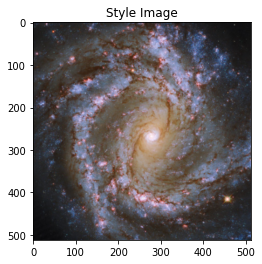

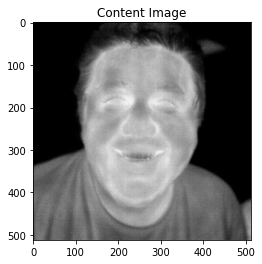

Building the style transfer model..
Optimizing..


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


run [50]:
Style Loss : 284.520355 Content Loss: 15.457801

run [100]:
Style Loss : 65.798248 Content Loss: 15.267547

run [150]:
Style Loss : 38.562191 Content Loss: 14.795575

run [200]:
Style Loss : 26.958778 Content Loss: 14.166210

run [250]:
Style Loss : 19.159842 Content Loss: 13.492489

run [300]:
Style Loss : 12.701813 Content Loss: 12.787275



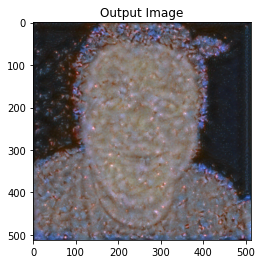

In [66]:
result_path = os.path.join(result_dir,'experiment_2_c.jpg')
run_pipeline(
    result_path,
    content_img_path = 'img/content_1.jpg', 
    style_img_path = 'img/style_1.jpg', 
    content_layers= ['conv_4'],
    style_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5'],
    style_weight = 8000000,
    content_weight = 1,
    num_steps=300,
    check_img_size = True
)


 ## Experiment 2-d : second combination for style loss (style weight) and content loss (content weight).

 |__Parameter__|__Value__|
 |---------|-----|
 |__Content Layers__|conv_4|
 |__Style Layers__|conv_1, conv_2, conv_3, conv_4, conv_5|
 |__Style Weight__|1000000|
 |__Content Weight__|200|

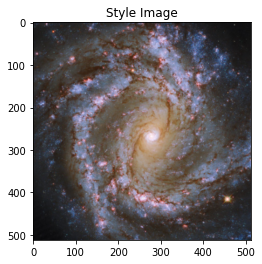

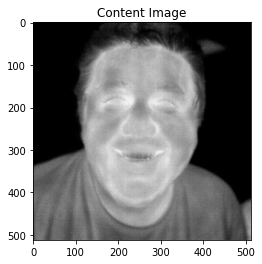

Building the style transfer model..
Optimizing..


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


run [50]:
Style Loss : 244.252274 Content Loss: 614.149841

run [100]:
Style Loss : 220.432556 Content Loss: 591.558289

run [150]:
Style Loss : 211.152420 Content Loss: 588.033142

run [200]:
Style Loss : 206.111343 Content Loss: 586.265259

run [250]:
Style Loss : 202.534088 Content Loss: 584.766785

run [300]:
Style Loss : 200.018784 Content Loss: 583.013367



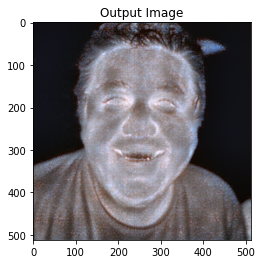

In [67]:
result_path = os.path.join(result_dir,'experiment_2_d.jpg')
run_pipeline(
    result_path,
    content_img_path = 'img/content_1.jpg', 
    style_img_path = 'img/style_1.jpg', 
    content_layers= ['conv_4'],
    style_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5'],
    style_weight = 1000000,
    content_weight = 200,
    num_steps=300,
    check_img_size = True
)


 ## Experiment 2-e : third combination for style loss (style weight) and content loss (content weight)

 |__Parameter__|__Value__|
 |---------|-----|
 |__Content Layers__|conv_4|
 |__Style Layers__|conv_1, conv_2, conv_3, conv_4, conv_5|
 |__Style Weight__|80|
 |__Content Weight__|1|

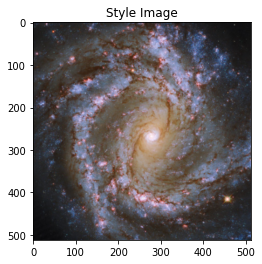

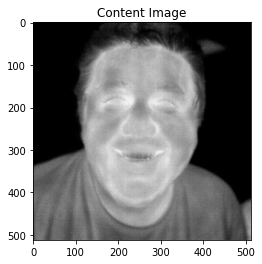

Building the style transfer model..
Optimizing..


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


run [50]:
Style Loss : 0.275536 Content Loss: 0.003520

run [100]:
Style Loss : 0.275046 Content Loss: 0.003762

run [150]:
Style Loss : 0.274813 Content Loss: 0.003885

run [200]:
Style Loss : 0.274687 Content Loss: 0.003949

run [250]:
Style Loss : 0.274590 Content Loss: 0.004002

run [300]:
Style Loss : 0.274527 Content Loss: 0.004033



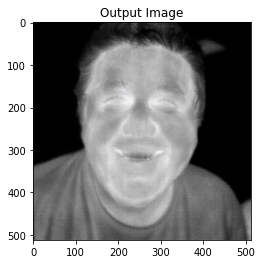

In [68]:
result_path = os.path.join(result_dir,'experiment_2_e.jpg')
run_pipeline(
    result_path,
    content_img_path = 'img/content_1.jpg', 
    style_img_path = 'img/style_1.jpg', 
    content_layers= ['conv_4'],
    style_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5'],
    style_weight = 80,
    content_weight = 1,
    num_steps=300,
    check_img_size = True
)


 ## Experiment 2-f : third combination for style loss (style weight) and content loss (content weight)

 |__Parameter__|__Value__|
 |---------|-----|
 |__Content Layers__|conv_1|
 |__Style Layers__|conv_1|
 |__Style Weight__|80|
 |__Content Weight__|1|

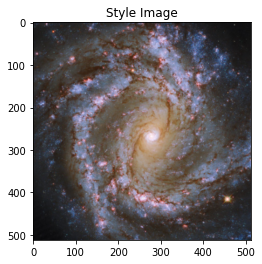

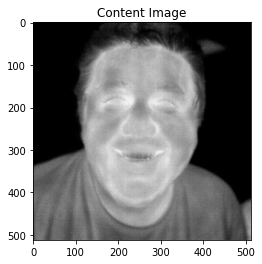

Building the style transfer model..
Optimizing..


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


run [50]:
Style Loss : 0.000801 Content Loss: 0.000000

run [100]:
Style Loss : 0.000801 Content Loss: 0.000000

run [150]:
Style Loss : 0.000801 Content Loss: 0.000000

run [200]:
Style Loss : 0.000801 Content Loss: 0.000000

run [250]:
Style Loss : 0.000801 Content Loss: 0.000000

run [300]:
Style Loss : 0.000801 Content Loss: 0.000000



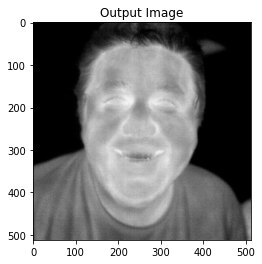

In [69]:
result_path = os.path.join(result_dir,'experiment_2_f.jpg')
run_pipeline(
    result_path,
    content_img_path = 'img/content_1.jpg', 
    style_img_path = 'img/style_1.jpg', 
    content_layers= ['conv_1'],
    style_layers = ['conv_1'],
    style_weight = 80,
    content_weight = 1,
    num_steps=300,
    check_img_size = True
)


 ## Experiment 2-g : third combination for style loss (style weight) and content loss (content weight)

 |__Parameter__|__Value__|
 |---------|-----|
 |__Content Layers__|conv_1|
 |__Style Layers__|conv_5|
 |__Style Weight__|80|
 |__Content Weight__|1|

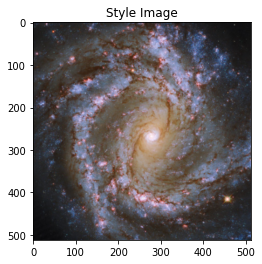

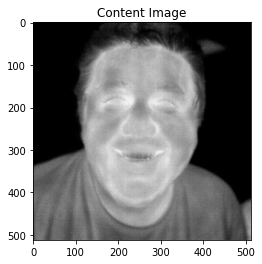

Building the style transfer model..
Optimizing..


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


run [50]:
Style Loss : 0.002840 Content Loss: 0.010001

run [100]:
Style Loss : 0.644923 Content Loss: 0.218370

run [150]:
Style Loss : 0.002773 Content Loss: 0.010614

run [200]:
Style Loss : 0.012547 Content Loss: 0.025422

run [250]:
Style Loss : 0.004737 Content Loss: 0.027122

run [300]:
Style Loss : 597.699158 Content Loss: 9.347672



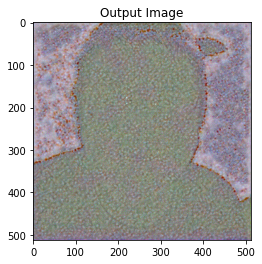

In [70]:
result_path = os.path.join(result_dir,'experiment_2_g.jpg')
run_pipeline(
    result_path,
    content_img_path = 'img/content_1.jpg', 
    style_img_path = 'img/style_1.jpg', 
    content_layers= ['conv_1'],
    style_layers = ['conv_5'],
    style_weight = 80,
    content_weight = 1,
    num_steps=300,
    check_img_size = True
)


 ## Experiment 3-a : original values for hyperparameters

 |__Parameter__|__Value__|
 |---------|-----|
 |__Content Layers__|conv_4|
 |__Style Layers__|conv_1, conv_2, conv_3, conv_4, conv_5|
 |__Style Weight__|1000000|
 |__Content Weight__|1|

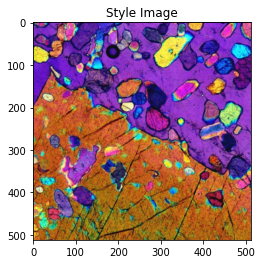

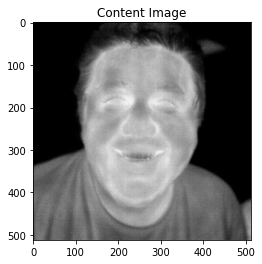

Building the style transfer model..
Optimizing..


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


run [50]:
Style Loss : 760.406982 Content Loss: 44.537388

run [100]:
Style Loss : 205.459030 Content Loss: 45.727657

run [150]:
Style Loss : 70.360977 Content Loss: 45.600163

run [200]:
Style Loss : 27.890398 Content Loss: 45.159576

run [250]:
Style Loss : 11.878591 Content Loss: 44.317146

run [300]:
Style Loss : 5.401732 Content Loss: 43.183533



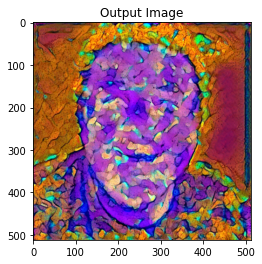

In [71]:
result_path = os.path.join(result_dir,'experiment_3_a.jpg')
run_pipeline(
    result_path,
    content_img_path = 'img/content_1.jpg', 
    style_img_path = 'img/style_2.jpg', 
    content_layers= ['conv_4'],
    style_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5'],
    style_weight = 1000000,
    content_weight = 1,
    num_steps=300,
    check_img_size = True
)


 ## Experiment 3-b : other selection of layers to calculate the loss functions

 |__Parameter__|__Value__|
 |---------|-----|
 |__Content Layers__|conv_2, conv_4, conv_5|
 |__Style Layers__|conv_3, conv_4, conv_5|
 |__Style Weight__|1000000|
 |__Content Weight__|1|

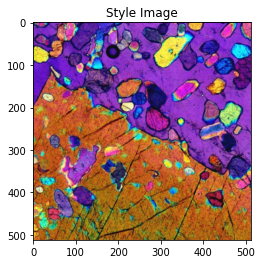

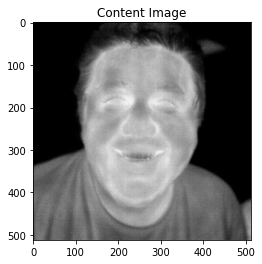

Building the style transfer model..
Optimizing..


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


run [50]:
Style Loss : 603.811707 Content Loss: 171.753220

run [100]:
Style Loss : 187.366974 Content Loss: 176.532745

run [150]:
Style Loss : 80.714218 Content Loss: 173.736053

run [200]:
Style Loss : 38.222408 Content Loss: 169.692261

run [250]:
Style Loss : 20.654650 Content Loss: 165.325073

run [300]:
Style Loss : 11.502291 Content Loss: 161.472275



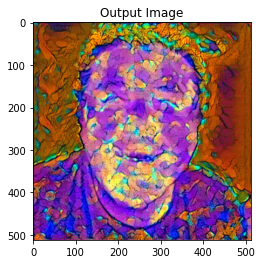

In [72]:
result_path = os.path.join(result_dir,'experiment_3_b.jpg')
run_pipeline(
    result_path,
    content_img_path = 'img/content_1.jpg', 
    style_img_path = 'img/style_2.jpg', 
    content_layers= ['conv_2', 'conv_4', 'conv_5'],
    style_layers = ['conv_1', 'conv_2', 'conv_5'],
    style_weight = 1000000,
    content_weight = 1,
    num_steps=300,
    check_img_size = True
)


 ## Experiment 3-c : first combination for style loss (style weight) and content loss (content weight)

 |__Parameter__|__Value__|
 |---------|-----|
 |__Content Layers__|conv_4|
 |__Style Layers__|conv_1, conv_2, conv_3, conv_4, conv_5|
 |__Style Weight__|8000000|
 |__Content Weight__|1|

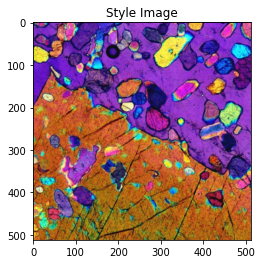

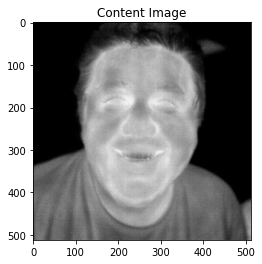

Building the style transfer model..
Optimizing..


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


run [50]:
Style Loss : 6050.888672 Content Loss: 44.796028

run [100]:
Style Loss : 2213.977295 Content Loss: 46.353912

run [150]:
Style Loss : 577.673462 Content Loss: 46.313007

run [200]:
Style Loss : 235.122025 Content Loss: 46.477669

run [250]:
Style Loss : 97.350388 Content Loss: 46.491810

run [300]:
Style Loss : 43.314438 Content Loss: 46.371513



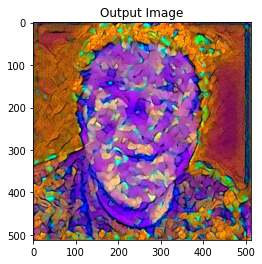

In [73]:
result_path = os.path.join(result_dir,'experiment_3_c.jpg')
run_pipeline(
    result_path,
    content_img_path = 'img/content_1.jpg', 
    style_img_path = 'img/style_2.jpg', 
    content_layers= ['conv_4'],
    style_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5'],
    style_weight = 8000000,
    content_weight = 1,
    num_steps=300,
    check_img_size = True
)


 ## Experiment 3-d : second combination for style loss (style weight) and content loss (content weight).

 |__Parameter__|__Value__|
 |---------|-----|
 |__Content Layers__|conv_4|
 |__Style Layers__|conv_1, conv_2, conv_3, conv_4, conv_5|
 |__Style Weight__|1000000|
 |__Content Weight__|200|

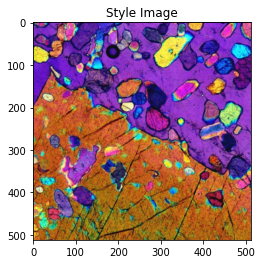

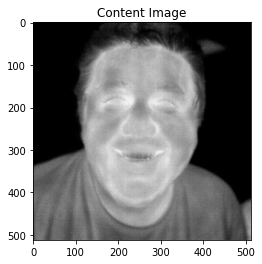

Building the style transfer model..
Optimizing..


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


run [50]:
Style Loss : 1602.396362 Content Loss: 5752.268555

run [100]:
Style Loss : 991.261780 Content Loss: 5151.816406

run [150]:
Style Loss : 840.128967 Content Loss: 4884.791016

run [200]:
Style Loss : 811.468384 Content Loss: 4775.665039

run [250]:
Style Loss : 820.665405 Content Loss: 4717.999023

run [300]:
Style Loss : 22346378.000000 Content Loss: 82232.937500



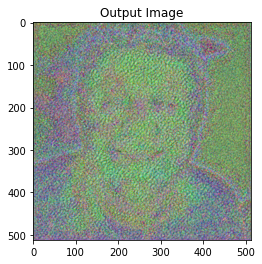

In [74]:
result_path = os.path.join(result_dir,'experiment_3_d.jpg')
run_pipeline(
    result_path,
    content_img_path = 'img/content_1.jpg', 
    style_img_path = 'img/style_2.jpg', 
    content_layers= ['conv_4'],
    style_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5'],
    style_weight = 1000000,
    content_weight = 200,
    num_steps=300,
    check_img_size = True
)


 ## Experiment 3-e : third combination for style loss (style weight) and content loss (content weight)

 |__Parameter__|__Value__|
 |---------|-----|
 |__Content Layers__|conv_4|
 |__Style Layers__|conv_1, conv_2, conv_3, conv_4, conv_5|
 |__Style Weight__|80|
 |__Content Weight__|1|

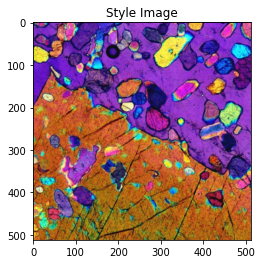

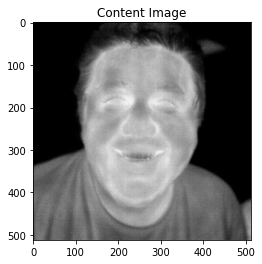

Building the style transfer model..
Optimizing..


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


run [50]:
Style Loss : 4.826726 Content Loss: 0.150646

run [100]:
Style Loss : 4.405045 Content Loss: 0.472468

run [150]:
Style Loss : 3.755534 Content Loss: 0.950958

run [200]:
Style Loss : 3.773621 Content Loss: 0.849363

run [250]:
Style Loss : 3.674789 Content Loss: 0.932445

run [300]:
Style Loss : 3.656037 Content Loss: 1.238521



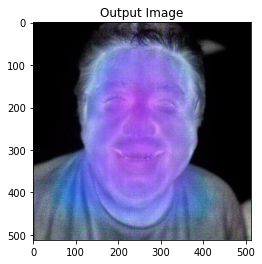

In [75]:
result_path = os.path.join(result_dir,'experiment_3_e.jpg')
run_pipeline(
    result_path,
    content_img_path = 'img/content_1.jpg', 
    style_img_path = 'img/style_2.jpg', 
    content_layers= ['conv_4'],
    style_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5'],
    style_weight = 80,
    content_weight = 1,
    num_steps=300,
    check_img_size = True
)


 ## Experiment 3-f : third combination for style loss (style weight) and content loss (content weight)

 |__Parameter__|__Value__|
 |---------|-----|
 |__Content Layers__|conv_1|
 |__Style Layers__|conv_1|
 |__Style Weight__|80|
 |__Content Weight__|1|

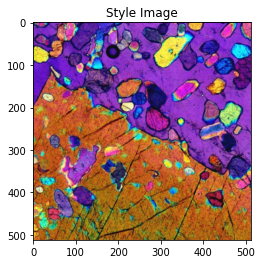

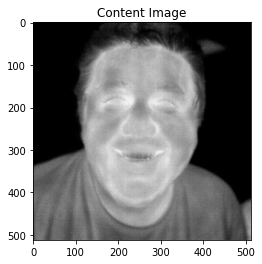

Building the style transfer model..
Optimizing..


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


run [50]:
Style Loss : 0.018994 Content Loss: 0.000000

run [100]:
Style Loss : 0.018993 Content Loss: 0.000000

run [150]:
Style Loss : 0.018993 Content Loss: 0.000000

run [200]:
Style Loss : 0.018993 Content Loss: 0.000000

run [250]:
Style Loss : 0.018992 Content Loss: 0.000000

run [300]:
Style Loss : 0.018992 Content Loss: 0.000000



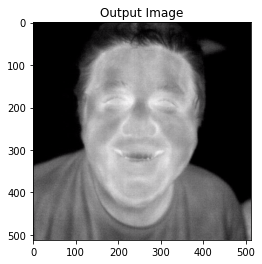

In [76]:
result_path = os.path.join(result_dir,'experiment_3_f.jpg')
run_pipeline(
    result_path,
    content_img_path = 'img/content_1.jpg', 
    style_img_path = 'img/style_2.jpg', 
    content_layers= ['conv_1'],
    style_layers = ['conv_1'],
    style_weight = 80,
    content_weight = 1,
    num_steps=300,
    check_img_size = True
)


 ## Experiment 3-g : third combination for style loss (style weight) and content loss (content weight)

 |__Parameter__|__Value__|
 |---------|-----|
 |__Content Layers__|conv_1|
 |__Style Layers__|conv_5|
 |__Style Weight__|80|
 |__Content Weight__|1|

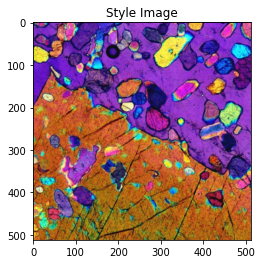

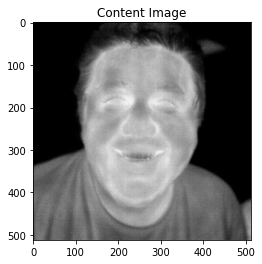

Building the style transfer model..
Optimizing..


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


run [50]:
Style Loss : 0.056990 Content Loss: 0.129893

run [100]:
Style Loss : 0.087269 Content Loss: 0.252810

run [150]:
Style Loss : 0.037835 Content Loss: 0.134530

run [200]:
Style Loss : 0.046387 Content Loss: 0.135045

run [250]:
Style Loss : 0.042440 Content Loss: 0.191516

run [300]:
Style Loss : 0.060754 Content Loss: 0.365964



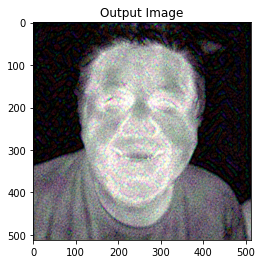

In [77]:
result_path = os.path.join(result_dir,'experiment_3_g.jpg')
run_pipeline(
    result_path,
    content_img_path = 'img/content_1.jpg', 
    style_img_path = 'img/style_2.jpg', 
    content_layers= ['conv_1'],
    style_layers = ['conv_5'],
    style_weight = 80,
    content_weight = 1,
    num_steps=300,
    check_img_size = True
)